In [39]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [2]:
data= pd.read_csv(r'C:\Users\Mohit\Downloads\FER dataset\fer2013.csv')

In [3]:
data.head(4)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training


In [4]:
data.shape

(35887, 3)

In [4]:
data.columns


Index(['emotion', 'pixels', 'Usage'], dtype='object')

In [5]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [3]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [4]:
data.emotion.value_counts()


3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

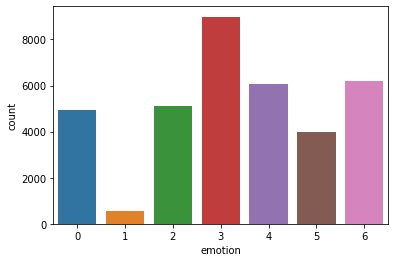

In [8]:
# plotting the counts 
sns.countplot(data['emotion'])


### lets check the pixels

In [9]:
print(math.sqrt(len(data['pixels'][0].split(' ')))) # 48 * 48  is the shape of the pic

48.0


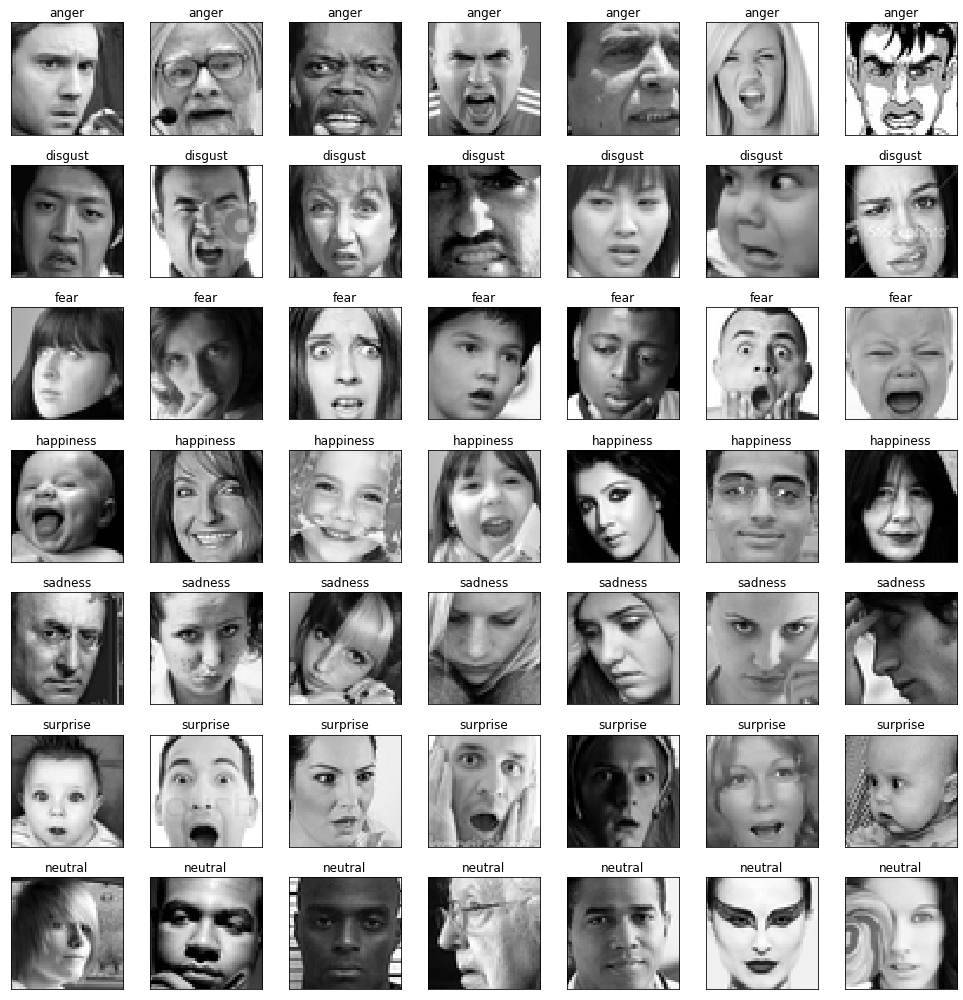

In [5]:
# lets plot this pixels so we can see the image
fig =plt.figure(1, (14, 14))

k = 0 
for label in sorted(data.emotion.unique()):
    for j in range(7):
        px = data[data.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        
        k += 1
        ax = plt.subplot(7,7,k)
        ax.imshow(px,cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [6]:
# As we do EDA on data we find the disupt(1) is have very few data
interested_labels= [3,4,6]
data = data[data.emotion.isin(interested_labels)]
data.head()

,emotion,pixels,Usage
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [34]:
# img_array = data.pixels.apply(lambda x : np.array(x.split(' ')).reshape(48,48,1).astype('float32'))
# img_array = np.stack(img_array, axis=0)

In [9]:
data.shape

(21264, 3)

In [36]:
# from pickle import dump, load
# dump(img_array, open('features.pkl', 'wb'))

In [12]:
with open('features.pkl','rb') as f:
    img_arr = pickle.load(f)


In [13]:
img_arr.shape

(21264, 48, 48, 1)

In [14]:
# Now we do the label encoding of the emotion labels
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


In [15]:
le = LabelEncoder()
img_labels = le.fit_transform(data.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [16]:
le_class = dict(zip(le.classes_, le.transform(le.classes_)))

In [17]:
le_class

{3: 0, 4: 1, 6: 2}

### Splitting the data into training and validation set.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_labels, test_size=0.1, random_state=42)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [22]:

# del data
del img_labels


In [23]:
img_width = X_train.shape[0]
img_height = X_train.shape[1]
img_depth= X_train.shape[2]
num_classes = y_train.shape[1]

In [24]:
img_width, img_height, img_depth, num_classes 

(19137, 48, 48, 3)

In [25]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_test = X_test / 255.

In [28]:
from keras.layers import Dense, Conv2D , MaxPool2D ,BatchNormalization , Flatten, ELU, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.models import Sequential
from keras.optimizers import Adam

In [29]:
###  Now lets build the network

model = Sequential()
model.add(Conv2D(64, (3,3) , activation='relu', padding ='same' , kernel_initializer='he_normal', input_shape=(48,48,1)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3) , activation='relu', padding ='same' , kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3) , activation='relu', padding ='same' , kernel_initializer='he_normal'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3) , activation='relu', padding ='same' , kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3,3) , activation='relu', padding ='same' , kernel_initializer='he_normal'))
model.add(BatchNormalization())
          
model.add(Conv2D(256, (3,3) , activation='relu', padding ='same' , kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu' , kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu' , kernel_initializer='he_normal'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)      

In [31]:
optim = Adam(learning_rate=0.001)


In [32]:
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [58]:
# model.summary()

In [34]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

callbacks = [early_stopping]

In [35]:
train_datagen = ImageDataGenerator(
                    rotation_range=15,
                    width_shift_range=0.15,
                    height_shift_range=0.15,
                    shear_range=0.15,
                    zoom_range=0.15,
                    horizontal_flip=True,
                )
train_datagen.fit(X_train)

Physical devices cannot be modified after being initialized


In [36]:
batch_size = 32 
epochs = 20


In [37]:
history = model.fit_generator(
            train_datagen.flow(X_train, y_train, batch_size=batch_size),
            steps_per_epoch=len(X_train)// batch_size ,
            validation_data=(X_test,y_test),
            epochs=epochs,
            
            callbacks=callbacks
)



Epoch 1/20


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_1/convolution (defined at C:\Users\Mohit\Anaconda3\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_6808]

Function call stack:
keras_scratch_graph


In [66]:
model.save('model.h5')

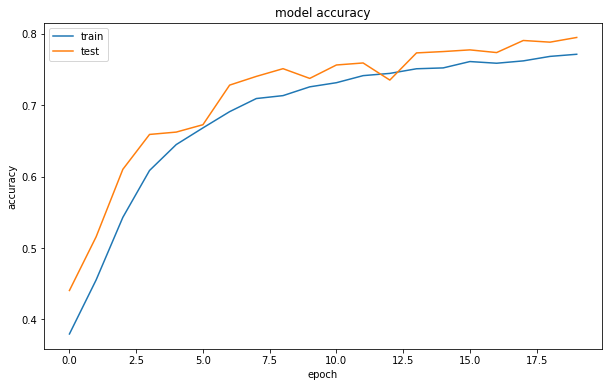

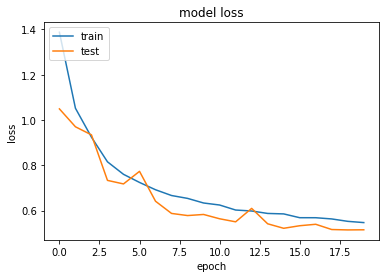

In [64]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

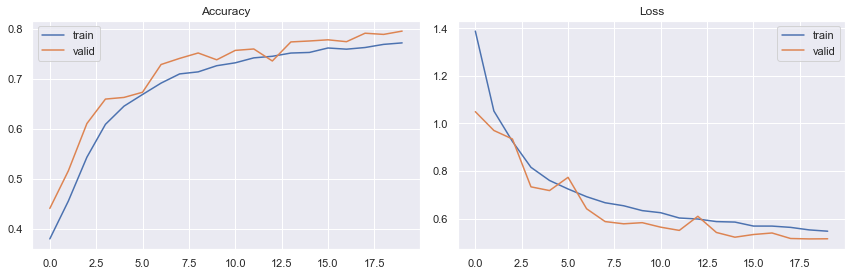

In [65]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()

In [68]:
pred = model.predict_classes(X_test)
print(classification_report(np.argmax(y_test, axis=1), pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       902
           1       0.75      0.71      0.73       593
           2       0.70      0.72      0.71       632

    accuracy                           0.80      2127
   macro avg       0.78      0.78      0.78      2127
weighted avg       0.79      0.80      0.79      2127



In [80]:
import sklearn
sklearn.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), pred)

TypeError: plot_confusion_matrix() missing 1 required positional argument: 'y_true'